In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc

**Load and normalize the data**

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [3]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [4]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [5]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [6]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Resnet**

In [8]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [11]:
start_time = time.time()

In [12]:
epochs = 30
patience = 5
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:59<57:39, 119.31s/it]

Epoch 1
Training Loss: 1.15972318290432 
Training Accuracy: 56.94062449441838%
Validation Loss: 1.028638577122405 
Validation Accuracy: 59.74761365474842%
Validation Loss Decreased(inf--->1.028639) 
Saving The Model


  7%|▋         | 2/30 [04:07<57:59, 124.26s/it]

Epoch 2
Training Loss: 0.7851583068222963 
Training Accuracy: 71.0726419673192%
Validation Loss: 0.7193977991431875 
Validation Accuracy: 75.2952596667206%
Validation Loss Decreased(1.028639--->0.719398) 
Saving The Model


 10%|█         | 3/30 [06:19<57:39, 128.14s/it]

Epoch 3
Training Loss: 0.6338727496545136 
Training Accuracy: 76.7836919592299%
Validation Loss: 0.5532690856499881 
Validation Accuracy: 80.10839669956317%
Validation Loss Decreased(0.719398--->0.553269) 
Saving The Model
Epoch 4
Training Loss: 0.5421617780005901 
Training Accuracy: 80.10030739362563%
Validation Loss: 0.46308344893292247 
Validation Accuracy: 82.21161624332632%
Validation Loss Decreased(0.553269--->0.463083) 
Saving The Model


 17%|█▋        | 5/30 [11:06<57:40, 138.42s/it]

Epoch 5
Training Loss: 0.4753365613693415 
Training Accuracy: 82.5756350105161%
Validation Loss: 0.681458515021228 
Validation Accuracy: 77.05872836110662%


 20%|██        | 6/30 [13:32<56:22, 140.95s/it]

Epoch 6
Training Loss: 0.41692690870866606 
Training Accuracy: 85.05905193334412%
Validation Loss: 0.36998320738628543 
Validation Accuracy: 86.8629671574179%
Validation Loss Decreased(0.463083--->0.369983) 
Saving The Model


 23%|██▎       | 7/30 [15:55<54:19, 141.71s/it]

Epoch 7
Training Loss: 0.37041839874453014 
Training Accuracy: 86.66882381491668%
Validation Loss: 0.4596676390223417 
Validation Accuracy: 83.80520951302378%


 27%|██▋       | 8/30 [18:34<53:53, 146.96s/it]

Epoch 8
Training Loss: 0.34436393971976076 
Training Accuracy: 87.87413039961172%
Validation Loss: 0.35431929658472694 
Validation Accuracy: 87.51820093835948%
Validation Loss Decreased(0.369983--->0.354319) 
Saving The Model


 30%|███       | 9/30 [20:54<50:41, 144.84s/it]

Epoch 9
Training Loss: 0.30481484258975783 
Training Accuracy: 89.1522407377447%
Validation Loss: 0.28894481613500483 
Validation Accuracy: 89.32211616243326%
Validation Loss Decreased(0.354319--->0.288945) 
Saving The Model


 33%|███▎      | 10/30 [23:22<48:36, 145.84s/it]

Epoch 10
Training Loss: 0.2628443400912199 
Training Accuracy: 91.02087040931887%
Validation Loss: 0.2044906113272682 
Validation Accuracy: 92.8975893868306%
Validation Loss Decreased(0.288945--->0.204491) 
Saving The Model


 37%|███▋      | 11/30 [25:48<46:12, 145.93s/it]

Epoch 11
Training Loss: 0.24153556961575837 
Training Accuracy: 91.50622876557192%
Validation Loss: 0.22046102955937386 
Validation Accuracy: 92.50121339589063%


 40%|████      | 12/30 [28:15<43:54, 146.39s/it]

Epoch 12
Training Loss: 0.21629578817529888 
Training Accuracy: 92.62255298495388%
Validation Loss: 0.23056066284095747 
Validation Accuracy: 91.94305128619965%


 43%|████▎     | 13/30 [30:47<41:54, 147.94s/it]

Epoch 13
Training Loss: 0.2099289468005877 
Training Accuracy: 92.63873159682899%
Validation Loss: 0.24089755886053854 
Validation Accuracy: 92.00776573370005%
Epoch 14
Training Loss: 0.19962790874326336 
Training Accuracy: 93.19689370651999%
Validation Loss: 0.16332371903520837 
Validation Accuracy: 94.42646820902766%
Validation Loss Decreased(0.204491--->0.163324) 
Saving The Model


 50%|█████     | 15/30 [35:52<37:34, 150.30s/it]

Epoch 15
Training Loss: 0.15043874380469938 
Training Accuracy: 94.68532599902929%
Validation Loss: 0.2743468355021659 
Validation Accuracy: 91.09367416275684%


 53%|█████▎    | 16/30 [38:24<35:08, 150.62s/it]

Epoch 16
Training Loss: 0.15452361588176214 
Training Accuracy: 94.59634363371623%
Validation Loss: 0.19549177796880712 
Validation Accuracy: 93.23734023620773%
Epoch 17
Training Loss: 0.13736456416990098 
Training Accuracy: 95.38100630965863%
Validation Loss: 0.14641212873059764 
Validation Accuracy: 95.26775602653292%
Validation Loss Decreased(0.163324--->0.146412) 
Saving The Model


 60%|██████    | 18/30 [42:02<25:50, 129.20s/it]

Epoch 18
Training Loss: 0.13619535786246528 
Training Accuracy: 95.46998867497169%
Validation Loss: 0.11988785997206389 
Validation Accuracy: 96.17375829153859%
Validation Loss Decreased(0.146412--->0.119888) 
Saving The Model


 63%|██████▎   | 19/30 [43:48<22:23, 122.17s/it]

Epoch 19
Training Loss: 0.13412369112183342 
Training Accuracy: 95.38100630965863%
Validation Loss: 0.12291357703073773 
Validation Accuracy: 95.89063258372431%


 67%|██████▋   | 20/30 [45:34<19:32, 117.29s/it]

Epoch 20
Training Loss: 0.10584340449085686 
Training Accuracy: 96.3193657984145%
Validation Loss: 0.14016165995479438 
Validation Accuracy: 95.46189936903414%


 70%|███████   | 21/30 [47:20<17:04, 113.84s/it]

Epoch 21
Training Loss: 0.12895015004098184 
Training Accuracy: 95.65604271153535%
Validation Loss: 0.1667664928159626 
Validation Accuracy: 94.49927196246563%


 73%|███████▎  | 22/30 [49:06<14:51, 111.50s/it]

Epoch 22
Training Loss: 0.10837780180909413 
Training Accuracy: 96.34363371622715%
Validation Loss: 0.09551184986764927 
Validation Accuracy: 97.17683222779486%
Validation Loss Decreased(0.119888--->0.095512) 
Saving The Model


 77%|███████▋  | 23/30 [50:51<12:48, 109.78s/it]

Epoch 23
Training Loss: 0.10247501396292517 
Training Accuracy: 96.60249150622876%
Validation Loss: 0.24376342060087725 
Validation Accuracy: 92.27471282963921%


 80%|████████  | 24/30 [52:37<10:51, 108.59s/it]

Epoch 24
Training Loss: 0.09661333290234363 
Training Accuracy: 96.61058081216632%
Validation Loss: 0.11880962179524907 
Validation Accuracy: 96.47306261122796%


 83%|████████▎ | 25/30 [54:23<08:58, 107.80s/it]

Epoch 25
Training Loss: 0.08682382647736234 
Training Accuracy: 97.06358194466915%
Validation Loss: 0.1577770349868027 
Validation Accuracy: 94.87138003559295%


 87%|████████▋ | 26/30 [56:09<07:08, 107.21s/it]

Epoch 26
Training Loss: 0.11359689033407362 
Training Accuracy: 96.30318718653939%
Validation Loss: 0.0879724062342998 
Validation Accuracy: 97.35479695842096%
Validation Loss Decreased(0.095512--->0.087972) 
Saving The Model


 90%|█████████ | 27/30 [57:55<05:20, 106.80s/it]

Epoch 27
Training Loss: 0.07938220274504708 
Training Accuracy: 97.15256430998221%
Validation Loss: 0.12866935514524888 
Validation Accuracy: 95.7288464649733%


 93%|█████████▎| 28/30 [59:41<03:33, 106.52s/it]

Epoch 28
Training Loss: 0.07755554834734504 
Training Accuracy: 97.52467238310953%
Validation Loss: 0.07324862792634933 
Validation Accuracy: 97.71881572561074%
Validation Loss Decreased(0.087972--->0.073249) 
Saving The Model


 97%|█████████▋| 29/30 [1:01:27<01:46, 106.42s/it]

Epoch 29
Training Loss: 0.07332104093603338 
Training Accuracy: 97.58129752467238%
Validation Loss: 0.12671571178542262 
Validation Accuracy: 96.02006147872513%


100%|██████████| 30/30 [1:03:13<00:00, 126.45s/it]

Epoch 30
Training Loss: 0.07626833323688903 
Training Accuracy: 97.50849377123443%
Validation Loss: 0.10110202212384793 
Validation Accuracy: 97.0554926387316%


In [13]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 63.22 minutes


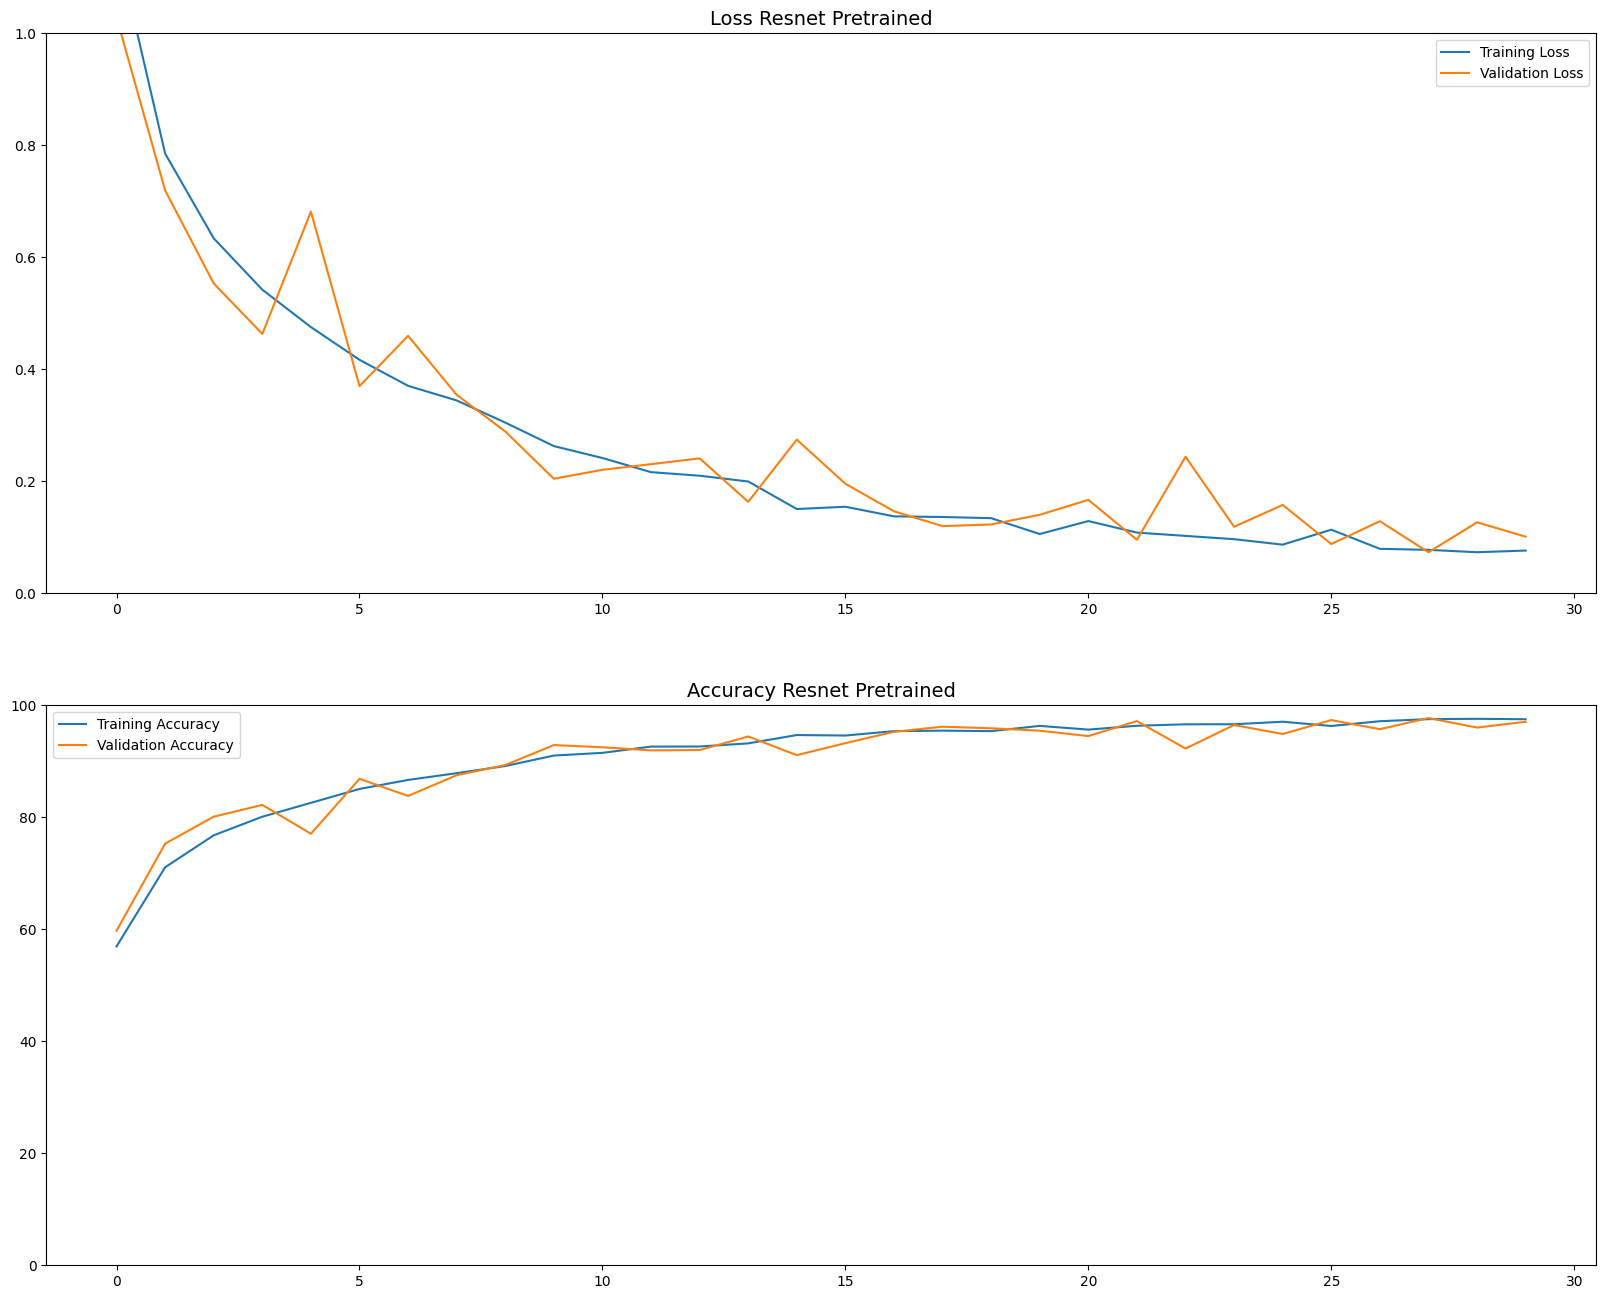

In [14]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [10]:
best_model_state = torch.load('resnet_pret.pth', map_location='cpu')
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(model_res, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')


-------------------------------------------------------
Best model's accuracy: 98.09092379873807
-------------------------------------------------------


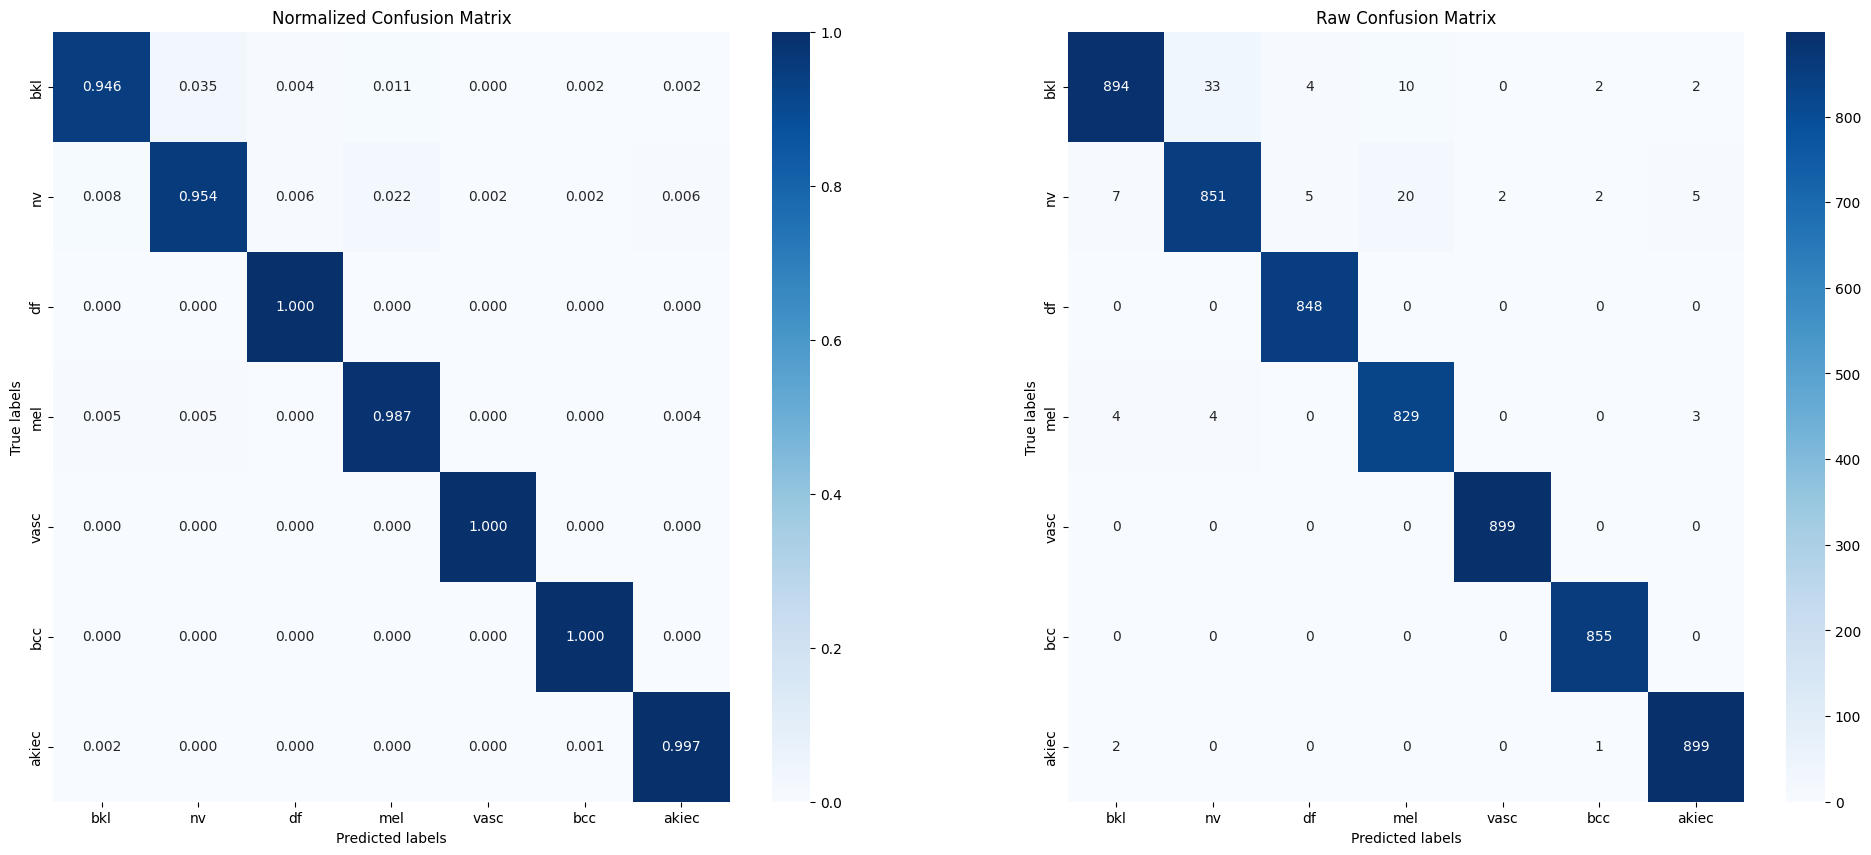

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.99      0.95      0.97       945
          nv       0.96      0.95      0.96       892
          df       0.99      1.00      0.99       848
         mel       0.97      0.99      0.98       840
        vasc       1.00      1.00      1.00       899
         bcc       0.99      1.00      1.00       855
       akiec       0.99      1.00      0.99       902

    accuracy                           0.98      6181
   macro avg       0.98      0.98      0.98      6181
weighted avg       0.98      0.98      0.98      6181

-------------------------------------------------------


In [12]:
Model_functions.conf_report(model_res, test_loader, 'resnet_conf_mat')

**Empty the CUDA memory**

In [19]:
torch.cuda.empty_cache() 
gc.collect()

2381

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **Densenet**

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [14]:
model_temp = 'densenet_pret'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/spyros/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [23]:
input_size = (3, 224, 224)
print(summary(model_des, input_size, device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [24]:
start_time = time.time()

In [25]:
epochs = 30
patience = 5
model_filename = 'densenet_pret.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:55<55:37, 115.10s/it]

Epoch 1
Training Loss: 0.8261477194091146 
Training Accuracy: 69.62465620449765%
Validation Loss: 0.7387107802453892 
Validation Accuracy: 73.38618346545866%
Validation Loss Decreased(inf--->0.738711) 
Saving The Model


  7%|▋         | 2/30 [03:49<53:36, 114.89s/it]

Epoch 2
Training Loss: 0.5516677750250474 
Training Accuracy: 79.81718168581136%
Validation Loss: 0.45847052482055445 
Validation Accuracy: 83.30367254489565%
Validation Loss Decreased(0.738711--->0.458471) 
Saving The Model


 10%|█         | 3/30 [05:44<51:42, 114.91s/it]

Epoch 3
Training Loss: 0.43051664754555824 
Training Accuracy: 84.6707652483417%
Validation Loss: 0.39533784592798515 
Validation Accuracy: 85.49587445397185%
Validation Loss Decreased(0.458471--->0.395338) 
Saving The Model


 13%|█▎        | 4/30 [07:39<49:46, 114.85s/it]

Epoch 4
Training Loss: 0.358678858630956 
Training Accuracy: 87.42112926710888%
Validation Loss: 0.3331285779982882 
Validation Accuracy: 88.75586474680472%
Validation Loss Decreased(0.395338--->0.333129) 
Saving The Model


 17%|█▋        | 5/30 [09:34<47:49, 114.76s/it]

Epoch 5
Training Loss: 0.32545012278958807 
Training Accuracy: 88.65879307555412%
Validation Loss: 0.28737784574621716 
Validation Accuracy: 89.8236531305614%
Validation Loss Decreased(0.333129--->0.287378) 
Saving The Model


 20%|██        | 6/30 [11:28<45:51, 114.65s/it]

Epoch 6
Training Loss: 0.26617743119173887 
Training Accuracy: 90.48697621744054%
Validation Loss: 0.28083337190770363 
Validation Accuracy: 89.79938521274875%
Validation Loss Decreased(0.287378--->0.280833) 
Saving The Model


 23%|██▎       | 7/30 [13:22<43:55, 114.57s/it]

Epoch 7
Training Loss: 0.22882749899759774 
Training Accuracy: 91.84597961494904%
Validation Loss: 0.27155830569863704 
Validation Accuracy: 91.43342501213395%
Validation Loss Decreased(0.280833--->0.271558) 
Saving The Model


 27%|██▋       | 8/30 [15:17<41:59, 114.53s/it]

Epoch 8
Training Loss: 0.22190429074858203 
Training Accuracy: 92.45267756026533%
Validation Loss: 0.236189246923694 
Validation Accuracy: 91.51431807150946%
Validation Loss Decreased(0.271558--->0.236189) 
Saving The Model


 30%|███       | 9/30 [17:11<40:05, 114.53s/it]

Epoch 9
Training Loss: 0.18984332203248983 
Training Accuracy: 93.4072156608963%
Validation Loss: 0.22644415471308146 
Validation Accuracy: 91.4253357061964%
Validation Loss Decreased(0.236189--->0.226444) 
Saving The Model


 33%|███▎      | 10/30 [19:06<38:10, 114.53s/it]

Epoch 10
Training Loss: 0.17059026417642523 
Training Accuracy: 94.08671735965054%
Validation Loss: 0.1418726839731599 
Validation Accuracy: 95.0412554602815%
Validation Loss Decreased(0.226444--->0.141873) 
Saving The Model


 37%|███▋      | 11/30 [21:00<36:14, 114.47s/it]

Epoch 11
Training Loss: 0.15059652653202724 
Training Accuracy: 94.75004044652968%
Validation Loss: 0.13375652946762798 
Validation Accuracy: 95.44572075715904%
Validation Loss Decreased(0.141873--->0.133757) 
Saving The Model


 40%|████      | 12/30 [22:55<34:20, 114.50s/it]

Epoch 12
Training Loss: 0.14759113188130296 
Training Accuracy: 94.85520142371784%
Validation Loss: 0.1660128860500971 
Validation Accuracy: 94.240414172464%


 43%|████▎     | 13/30 [24:49<32:26, 114.48s/it]

Epoch 13
Training Loss: 0.12111504983099163 
Training Accuracy: 95.79356091247371%
Validation Loss: 0.11478010004444063 
Validation Accuracy: 96.58631289435367%
Validation Loss Decreased(0.133757--->0.114780) 
Saving The Model


 47%|████▋     | 14/30 [26:44<30:31, 114.47s/it]

Epoch 14
Training Loss: 0.12189224241806786 
Training Accuracy: 95.76929299466106%
Validation Loss: 0.10033748351766678 
Validation Accuracy: 96.81281346060508%
Validation Loss Decreased(0.114780--->0.100337) 
Saving The Model


 50%|█████     | 15/30 [28:38<28:36, 114.44s/it]

Epoch 15
Training Loss: 0.12878750605046635 
Training Accuracy: 95.68839993528555%
Validation Loss: 0.10448945100955877 
Validation Accuracy: 96.2870085746643%


 53%|█████▎    | 16/30 [30:33<26:42, 114.46s/it]

Epoch 16
Training Loss: 0.09298940319074582 
Training Accuracy: 96.9260637437308%
Validation Loss: 0.1414871282565097 
Validation Accuracy: 95.6155961818476%


 57%|█████▋    | 17/30 [32:27<24:47, 114.40s/it]

Epoch 17
Training Loss: 0.10701780053437988 
Training Accuracy: 96.32745510435204%
Validation Loss: 0.10155902878809672 
Validation Accuracy: 96.60249150622876%


 60%|██████    | 18/30 [34:21<22:52, 114.38s/it]

Epoch 18
Training Loss: 0.09516450006019045 
Training Accuracy: 96.72383109529203%
Validation Loss: 0.19266685638853495 
Validation Accuracy: 94.83902281184274%


 63%|██████▎   | 19/30 [36:16<20:58, 114.40s/it]

Epoch 19
Training Loss: 0.08961643631093551 
Training Accuracy: 96.99077819123119%
Validation Loss: 0.09865076212003077 
Validation Accuracy: 96.99077819123119%
Validation Loss Decreased(0.100337--->0.098651) 
Saving The Model


 67%|██████▋   | 20/30 [38:10<19:03, 114.36s/it]

Epoch 20
Training Loss: 0.08382440775931267 
Training Accuracy: 97.0393140268565%
Validation Loss: 0.09013932396703489 
Validation Accuracy: 97.120207086232%
Validation Loss Decreased(0.098651--->0.090139) 
Saving The Model


 70%|███████   | 21/30 [40:04<17:08, 114.25s/it]

Epoch 21
Training Loss: 0.09954665608442984 
Training Accuracy: 96.5296877527908%
Validation Loss: 0.14634219781244148 
Validation Accuracy: 95.32438116809578%


 73%|███████▎  | 22/30 [41:58<15:13, 114.21s/it]

Epoch 22
Training Loss: 0.07733391044879193 
Training Accuracy: 97.40333279404626%
Validation Loss: 0.2742250991193457 
Validation Accuracy: 91.86215822682414%


 77%|███████▋  | 23/30 [43:52<13:19, 114.19s/it]

Epoch 23
Training Loss: 0.0743620502284201 
Training Accuracy: 97.54894030092218%
Validation Loss: 0.08643695422344738 
Validation Accuracy: 97.39524348810872%
Validation Loss Decreased(0.090139--->0.086437) 
Saving The Model


 80%|████████  | 24/30 [45:46<11:25, 114.21s/it]

Epoch 24
Training Loss: 0.0545813854209518 
Training Accuracy: 98.20417408186377%
Validation Loss: 0.10853611325826472 
Validation Accuracy: 96.55395567060346%


 83%|████████▎ | 25/30 [47:41<09:30, 114.17s/it]

Epoch 25
Training Loss: 0.08036379410869632 
Training Accuracy: 97.36288626435852%
Validation Loss: 0.0850684615956061 
Validation Accuracy: 97.38715418217117%
Validation Loss Decreased(0.086437--->0.085068) 
Saving The Model


 87%|████████▋ | 26/30 [49:35<07:36, 114.18s/it]

Epoch 26
Training Loss: 0.06276839776223318 
Training Accuracy: 98.09901310467562%
Validation Loss: 0.05782540044906725 
Validation Accuracy: 98.32551367092704%
Validation Loss Decreased(0.085068--->0.057825) 
Saving The Model


 90%|█████████ | 27/30 [51:29<05:42, 114.22s/it]

Epoch 27
Training Loss: 0.06183996602025928 
Training Accuracy: 97.8239767027989%
Validation Loss: 0.14686114753858795 
Validation Accuracy: 95.17877366121986%


 93%|█████████▎| 28/30 [53:23<03:48, 114.15s/it]

Epoch 28
Training Loss: 0.06892703807472374 
Training Accuracy: 97.71881572561074%
Validation Loss: 0.05868526232870746 
Validation Accuracy: 98.13945963436338%


 97%|█████████▋| 29/30 [55:17<01:54, 114.09s/it]

Epoch 29
Training Loss: 0.052612463926213 
Training Accuracy: 98.24462061155153%
Validation Loss: 0.07212585435065114 
Validation Accuracy: 97.7754408671736%


100%|██████████| 30/30 [57:11<00:00, 114.38s/it]

Epoch 30
Training Loss: 0.053385695963267726 
Training Accuracy: 98.14754894030092%
Validation Loss: 0.11631534595535202 
Validation Accuracy: 95.99579356091247%


In [26]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 57.34 minutes


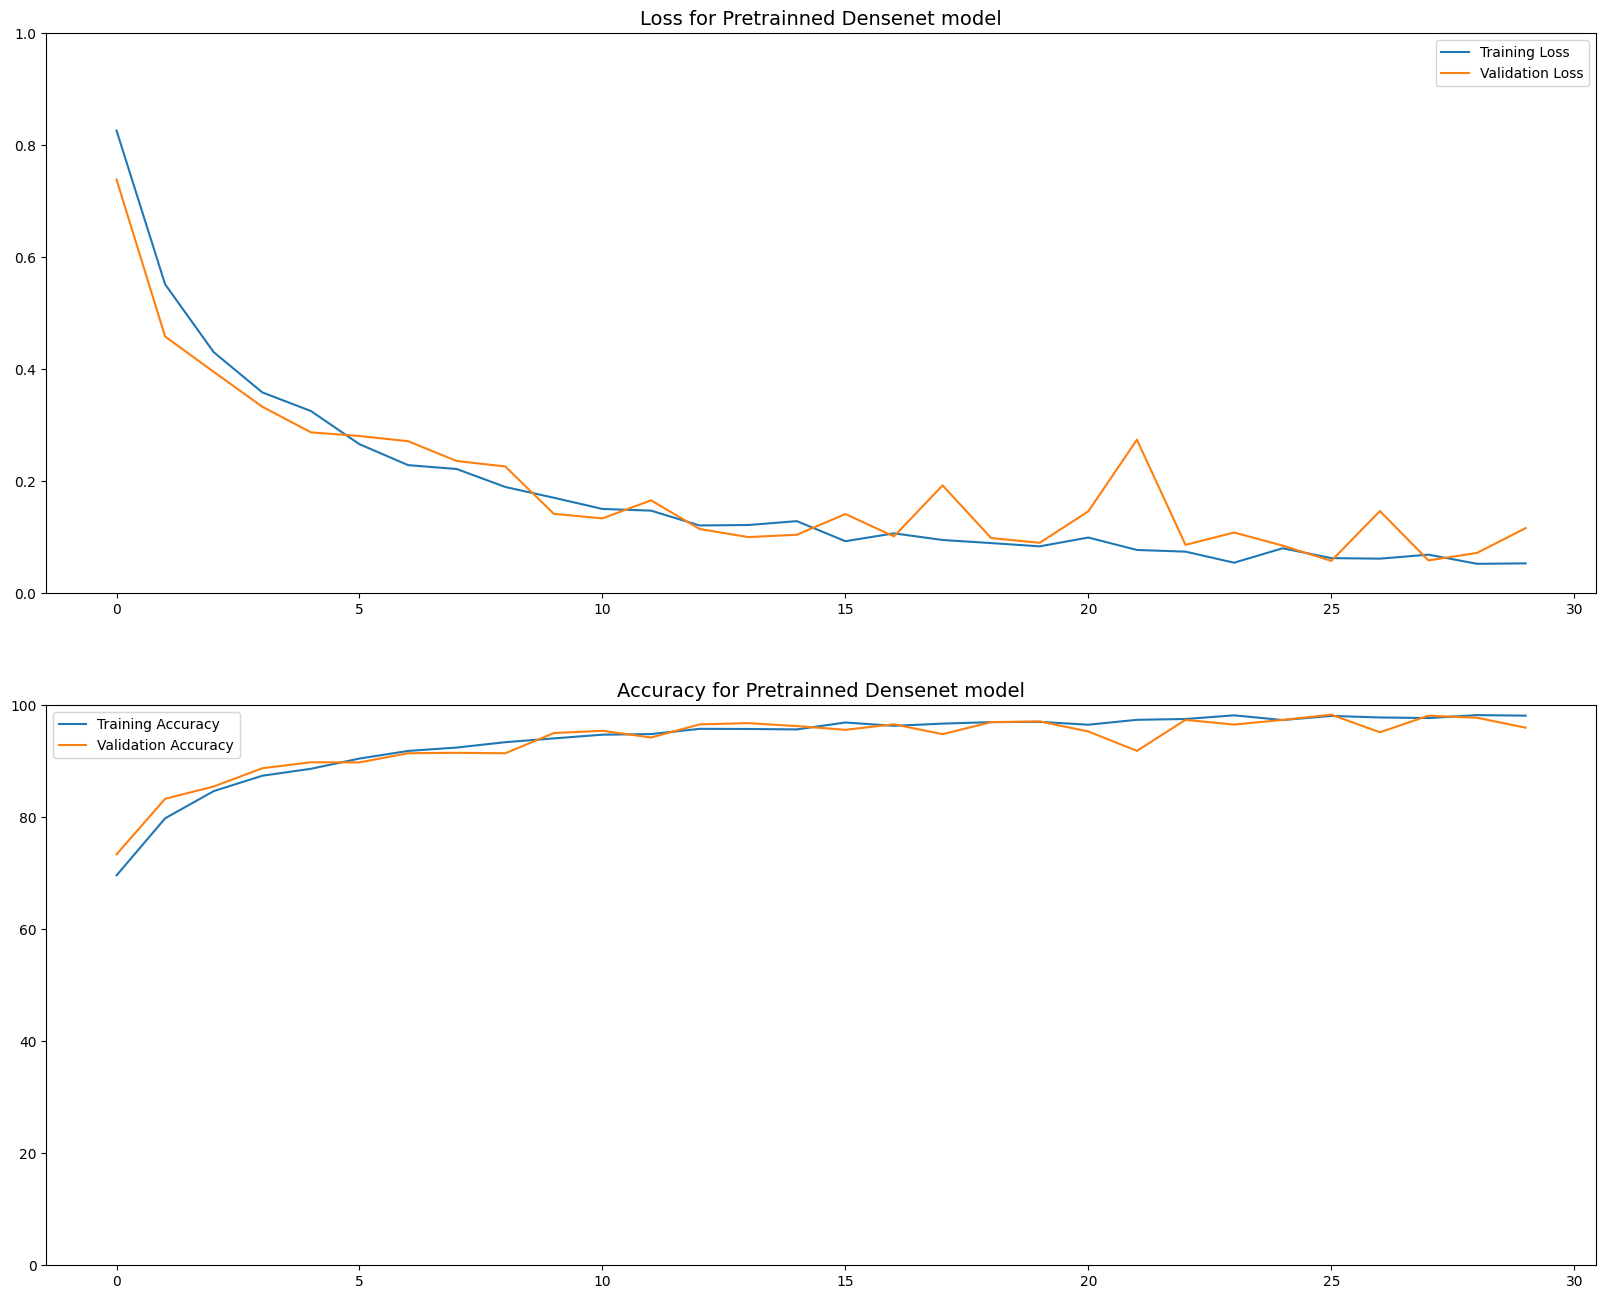

In [27]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)  
fig2.legend()
plt.show()

In [15]:
best_model_state = torch.load('densenet_pret.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 98.89985439249313
-------------------------------------------------------


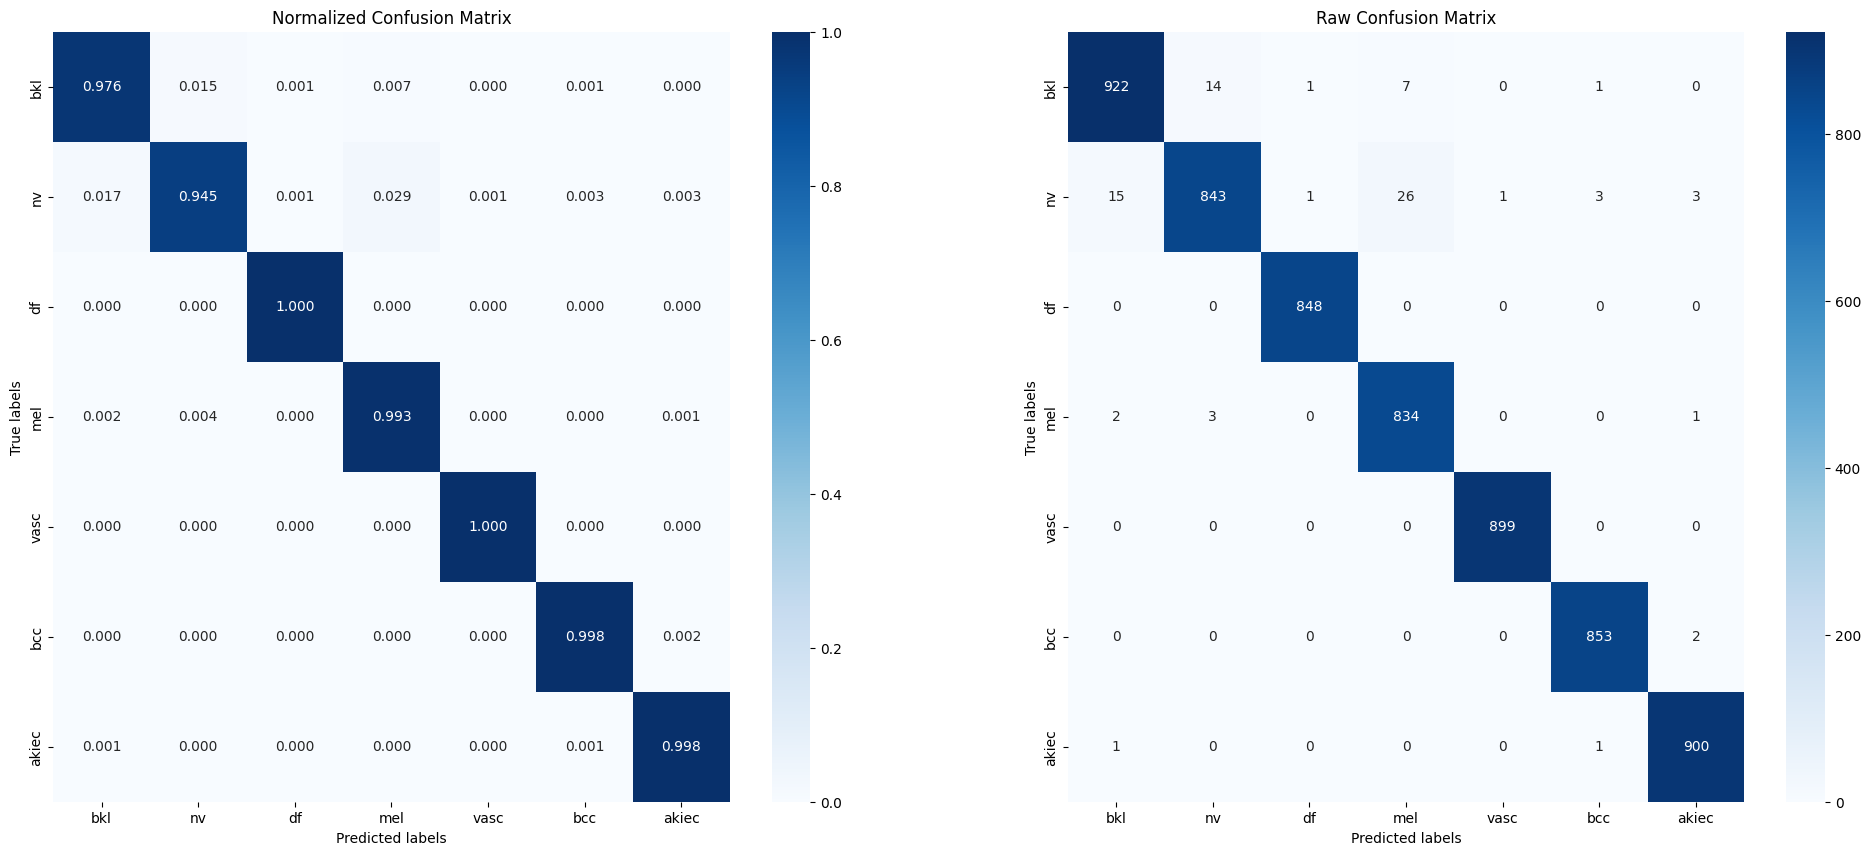

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.98      0.98      0.98       945
          nv       0.98      0.95      0.96       892
          df       1.00      1.00      1.00       848
         mel       0.96      0.99      0.98       840
        vasc       1.00      1.00      1.00       899
         bcc       0.99      1.00      1.00       855
       akiec       0.99      1.00      1.00       902

    accuracy                           0.99      6181
   macro avg       0.99      0.99      0.99      6181
weighted avg       0.99      0.99      0.99      6181

-------------------------------------------------------


In [17]:
Model_functions.conf_report(model_des, test_loader, 'densenet_conf_mat')